# Homework 1

**The following notebook is meant to help you work through Problems 2, 3, and 4 on Homework 1. You are by no means required to use it, nor are you required to fill out/use any of the boilerplate code/functions. You are welcome to implement the functions however you wish.**

In [15]:
# Loading data; no changes needed

import numpy as np
import matplotlib.pyplot as plt
from cmath import exp
train_data = np.genfromtxt("hw1/data/earth_temperature_sampled_train.csv", delimiter = ',')
year_train = train_data[:, 0] / 1000
temp_train = train_data[:, 1]
test_data = np.genfromtxt("hw1/data/earth_temperature_sampled_test.csv", delimiter = ',')
year_test = test_data[:, 0] / 1000
temp_test = test_data[:, 1]

In [31]:
# These are test functions for your implementations in Questions 2.1 and 3.1; no changes needed

def test_p2(kernel_regressor):
    """
    Run this only after you have implemented the function compute_loss, which returns the loss for a tau.
    Note that the test cases this Autograder uses are distinct from the tau values specified in the homework.
    """

    tau1, y1 = 3, [1.57, -5.04, -4.98924104, -2.74994907, -8.88]
    tau2, y2 = 90, [ 1.228045, -5.16138536, -4.16187715, -2.83729799, -8.31847509]
    tau3, y3 = 2700, [-3.46763865, -5.71861367, -4.87566622, -5.56020686, -5.18940151]

    test_pts = np.array([400, 500, 600, 700, 800])
    train_data = np.genfromtxt("hw1/data/earth_temperature_sampled_train.csv", delimiter = ',')[1:]
    year_train = train_data[:, 0] / 1000
    temp_train = train_data[:, 1]

    for tau, y in zip([tau1, tau2, tau3], [y1, y2, y3]):
        assert np.allclose(y, kernel_regressor(test_pts, tau, year_train, temp_train)), f"Failed for tau={tau}"
    
    print("Passed")

def test_p3(predict_knn):
    """
    Run this only after you have implemented the functions predict_kernel and predict_knn.
    """
    k1, y1 = 1, [1.57, -5.04, -4.99, -2.75, -8.88]
    k2, y2 = 3, [0.37333333, -5.19, -4.13, -2.63333333, -4.5]
    k3, y3 = 55, [-5.22981818, -5.22981818, -5.22981818, -5.41981818, -5.41981818]


    test_pts = np.array([400, 500, 600, 700, 800])
    train_data = np.genfromtxt("hw1/data/earth_temperature_sampled_train.csv", delimiter = ',')[1:]
    year_train = train_data[:, 0] / 1000
    temp_train = train_data[:, 1]

    for k, y in zip([k1, k2, k3], [y1, y2, y3]):
        assert np.allclose(y, predict_knn(test_pts, k, year_train, temp_train)), f"Failed for k={k}"

    print("Passed")

# Problem 2

## Problem 2 Subpart 1

In [29]:

def kernel_regressor(x_new, tau, x_train, y_train):
    """
    Kernel-based regression to predict values for new data points based on training data.
    
    :param x_new: Array of new data points for which predictions are needed.
    :param tau: The lengthscale parameter for the kernel function.
    :param x_train: Array of x values from the training data.
    :param y_train: Array of y values (targets) from the training data.
    :return: Predictions for each entry in x_new.
    """
    predictions = np.zeros_like(x_new)
    for i, x_star in enumerate(x_new):
        kernel_values = np.exp(-((x_train - x_star) ** 2) / tau)
        weighted_sum = np.sum(kernel_values * y_train)
        norm_factor = np.sum(kernel_values)
        predictions[i] = weighted_sum / norm_factor if norm_factor != 0 else 0
    return predictions

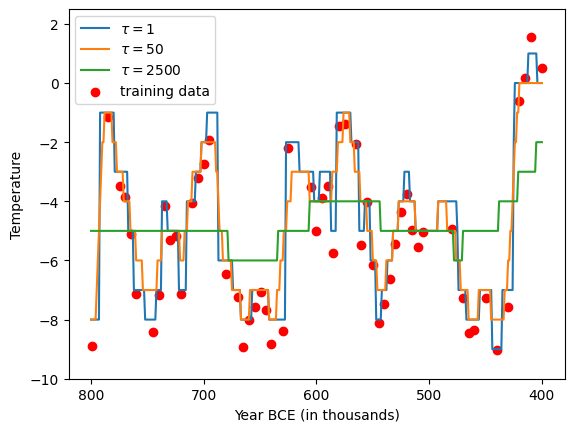

In [21]:
# plot functions
x_array = np.arange(400, 800 + 1, 1)
for tau in [1, 50, 2500]:
    plt.plot(x_array, kernel_regressor(x_array, tau, year_train, temp_train), label = f"$\\tau = {tau}$")
plt.scatter(year_train, temp_train, label = "training data", color = "red")
plt.legend()
plt.xticks(np.arange(400, 800 + 100, 100))
plt.ylabel("Temperature")
plt.xlabel("Year BCE (in thousands)")
plt.ylim([-10,2.5])

plt.gca().invert_xaxis()
# figure should be in your directory now, with name p1.2.png
plt.savefig("hw1/images/p1.2.png", bbox_inches = "tight")
plt.show()

## Problem 2 Subpart 4

In [30]:
def model_mse(predictions, true):
    """
    Calculate the MSE for the given model predictions, with respect to the true values

    :param predictions: predictions given by the model
    :param true: corresponding true values
    :return: the mean squared error
    """
    mse = np.mean((predictions - true) ** 2)
    return mse

# Calculating MSE for each tau and printing the results
for tau in [1, 50, 2500]:
    predictions = kernel_regressor(year_test, tau, year_train, temp_train)
    mse = model_mse(predictions, temp_test)
    print(f"tau = {tau}: loss = {mse}")

tau = 1: loss = 1.9472621565209178
tau = 50: loss = 1.8582899169613447
tau = 2500: loss = 8.333886806980791


In [23]:
for tau in [1, 50, 2500]:
    print(f"tau = {tau}: loss = {model_mse(kernel_regressor(year_test, tau, year_train, temp_train), temp_test)}")

tau = 1: loss = 1.9472621565209178
tau = 50: loss = 1.8582899169613447
tau = 2500: loss = 8.333886806980791


# Problem 3

## Problem 3 Subpart 1

In [32]:
# This function has been implemented for you.

def predict_knn(x_new, k, x_train, y_train):
    """
    Returns predictions for the values in x_test, using KNN predictor with the specified k.

    :param x_new: a numpy array of x_values on which to do prediction. Shape is (n,)
    :param k: number of nearest neighbors to consider
    :param x_train: x coordinates of training dataset
    :param y_train: y coordinates of training dataset

    :return: if x_array = [x_1, x_2, ...], then return [f(x_1), f(x_2), ...]
             where f is the kNN with specified parameters and training set
    """
    # weight matrix
    dists = np.exp(- (x_train - x_new.reshape(-1, 1)) ** 2 / 2500)
    # dividing by 2500 needed due to some stability issues at high distances

    # argsort the rows
    ix = dists.argsort(axis = 1)
    ix = ix[:, -k:] # take only the k smallest distances
    y = y_train[ix]

    # sum each row
    return np.mean(y, axis = 1)

In [33]:
test_p3(predict_knn)

Passed


FileNotFoundError: [Errno 2] No such file or directory: 'images/p2.1.png'

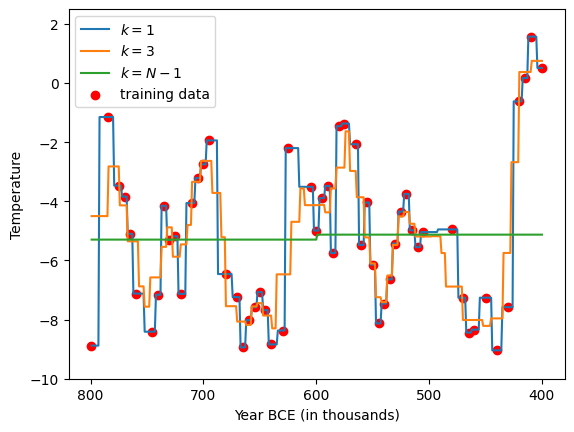

In [34]:
# plot functions
N = year_train.shape[0]
x_array = np.arange(400, 800, 1)
plt.plot(x_array, predict_knn(x_array, 1, year_train, temp_train), label = "$k = 1$")
plt.plot(x_array, predict_knn(x_array, 3, year_train, temp_train), label = "$k = 3$")
plt.plot(x_array, predict_knn(x_array, N - 1, year_train, temp_train), label = "$k = N - 1$")
plt.scatter(year_train, temp_train, label = "training data", color = "red")
plt.ylabel("Temperature")
plt.xlabel("Year BCE (in thousands)")

plt.legend()
plt.xticks(np.arange(400, 900, 100))
plt.ylim([-10,2.5])

plt.gca().invert_xaxis()
# figure should be in your directory now, with name p2.1.png
plt.savefig("hw1/images/p2.1.png", bbox_inches = "tight")
plt.show()

## Problem 3 Subpart 2

In [ ]:
# choose your value of k and calculate the loss
for k in [1, 3, 55, 56]:
    print(f"k = {k}: MSE loss = {model_mse(predict_knn(year_test, k, year_train, temp_train), temp_test)}")

In [ ]:
year_train.shape

# Problem 4

## Problem 4 Subpart 1

In [ ]:
def exp_kernel(x,mu):
    return np.exp(-1/float(5)*np.power(x-mu,2))

def f_scale(X, part = "a"):
  if part == "a":
    X = X/181 # 181000
  elif part == "b":
    X = X/4e2 # 4e5
  elif part == "c":
    X = X/1.81 # 1810    
  elif part == "d":
    X = X/.181 # 181
  return X

# TODO: Complete this `make_basis` function according to the above
# specifications. The function should return the array `phi(X)`

def make_basis(X,part='a'):
  """
  Args:
    X: input of years (or any variable you want to turn into the appropriate basis) as
      ndarray with length `N`.
    part: one of `a`, `b`, `c`, `d` depending on the basis function.

  Returns:
    ndarray `phi(X)` of shape `(N,D)`. For each part the shapes of your
    training data `make_basis(years_train)` should be
      (a) 57x10, (b) 57x10, (c) 57x10, (d) 57x50.
  """
  
  phi_X = [np.ones(X.shape).T]

  ### DO NOT CHANGE THIS SECTION 
  ### it is to prevent numerical instability from taking the exponents of
  ### the years, as well as break symmetry when dealing with a Fourier basis.
  X = f_scale(X, part)
  ### end section

  # Part a) has been provided for you as an example.
  if part == 'a':
    for j in range(1,10):
      phi_X.append(X**j)
    pass
  
  elif part=='b':
    pass

  elif part=='c':
    pass

  elif part=='d':
    pass

  return np.vstack(phi_X).T 

We are now solving the multi-dimensional OLS regression problem. For each $i=1,\ldots, N$, we have 
$$ \hat y_i = \mathbf{w}^\top\mathbf{\phi}(x_i) = \sum_{j=1}^D w_j \phi_j(x_i).  $$

We can find the weights that minimize the MSE $\frac 1N\| \mathbf{y} - \mathbf{\phi}(\mathbf{X})\mathbf{w}\| $ with the analytic solution described in the textbook at Derivation 2.6.1.
$$ \mathbf{w^*} = (\mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top \mathbf{y}. $$

In [ ]:
# Find the regression weights using the Moore-Penrose pseudoinverse.
def find_weights(X,y):
    w_star = np.dot(np.linalg.pinv(np.dot(X.T, X)), np.dot(X.T, y))
    return w_star

In [ ]:
_, ax = plt.subplots(2,2, figsize = (16,10))

for i, part in enumerate(['a', 'b', 'c' ,'d']):
  # Plotting the original data
  phi_years_train = make_basis(year_train, part)
  w = find_weights(phi_years_train, temp_train)

  
  ax[i//2, i%2].scatter(year_train, temp_train, label = "Original Data")
  
  xs = np.linspace(year_train.min(), year_train.max(), 1000)
  y_pred = [0 for _ in xs]
  ax[i//2, i%2].plot(xs, y_pred, color = 'orange', label = "Basis Regression")
  ax[i//2, i%2].set_xlabel("Year")
  ax[i//2, i%2].set_ylabel("Temperature")
  ax[i//2, i%2].set_title(f"OLS Basis Regression; Temperature on Years ({part})")

  ax[i//2, i%2].legend()

  # TODO: Plot the regression line generated by your model. 
  ax[i//2, i%2].invert_xaxis()
  
plt.savefig("images/p3.1.png")
  


## Problem 4 Subpart 2

In [ ]:
def mean_squared_error(X,y, w):
  # TODO: Given a linear regression model with parameter w, compute and return the
  # mean squared error.
  pass

def negative_log_likelihood(X,y,w, sigma):
  # TODO: Given a probabilistic linear regression model y = w^T x + e, where
  # e is N(0, sigma), return the negative log likelihood of the data X,y.
  pass


In [ ]:
for part in ['a', 'b', 'c', 'd']:
  # TODO: compute the MSE and Likelihood and Print the results
  train_mse = 181
  test_mse = 181
  
  print(f"\nPart ({part});\n\n Train MSE: {train_mse:.2f}; Test MSE: {test_mse:.2f}\n")
  
  # TODO: compute the likelihood. 
  train_log_nll = 181
  test_log_nll = 181
  print(f" Train Negative Log-Likelihood: {train_log_nll:.3f}; Test Negative Log-Likelihood: {test_log_nll:.3f}")